In [1]:
# Imports
import torch
use_cuda = torch.cuda.is_available()
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
%matplotlib inline
import sys
sys.path.append("wohlert") # add Wohlert's code: https://github.com/wohlert/semi-supervised-pytorch
print(f'cuda: {use_cuda}')

RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

fig_objects = [] # list of figures to be saved to a file
fig_names   = []

cuda: True


In [2]:
if (True):  # REFERENCE / BEST SETTINGS SO FAR
 # NN structure
 input_dim         = 18965 # gtex-gene features (can be reduced/capped for quicker tests if needed)
 latent_dim        = 32
 hidden_layers     = [512]

 # Data loader
 BATCH_SIZE        = 80
 NUM_WORKERS       = 4
 PREFETCH_FACTOR   = 2
 MAX_FEATURE_VALUE = 24 # Max value of features for normalization

 # Training pars
 TRAIN_EPOCHS      = 20
 LEARNING_RATE     = 1e-3
 BETA              = 0
 ELBO_GAIN         = 1 

else:       # FOR TESTING
 # NN structure
 input_dim         = 18965 # gtex-gene features (can be reduced/capped for quicker tests if needed)
 latent_dim        = 32
 hidden_layers     = [512]

 # Data loader
 BATCH_SIZE        = 32
 NUM_WORKERS       = 4
 PREFETCH_FACTOR   = 2
 MAX_FEATURE_VALUE = 1 # Max value of features for normalization

 # Training pars
 TRAIN_EPOCHS      = 5
 LEARNING_RATE     = 1e-4  # 0.3*1e-4: line, 3*1e-4 collapsed
 BETA              = 0.1
 ELBO_GAIN         = 1 

### Helper function to save results (variables and figures)

In [3]:
def save_results(filename, fig_objects, fig_names):

  # Extract directory from filename
  directory = os.path.dirname(filename)
  if not os.path.exists(directory):
    os.makedirs(directory)

 # Save variables
  with open(filename, 'w') as file: 
    file.write(f"NN structure:\n")
    file.write(f"==============\n")
    file.write(f"input_dim       = {input_dim}\n")
    file.write(f"latent_dim      = {latent_dim}\n")
    file.write(f"hidden layers   = {hidden_layers}\n")
    file.write(f"Data loader:\n")
    file.write(f"==============\n")
    file.write(f"BATCH_SIZE      = {BATCH_SIZE}\n")
    file.write(f"NUM_WORKERS     = {NUM_WORKERS}\n")
    file.write(f"PREFETCH_FACTOR = {PREFETCH_FACTOR}\n\n")
    file.write(f"Training pars:\n")
    file.write(f"==============\n")
    file.write(f"TRAIN_EPOCHS    = {TRAIN_EPOCHS}\n")
    file.write(f"LEARNING_RATE   = {LEARNING_RATE}\n")
    file.write(f"BETA            = {BETA}\n")
    file.write(f"ELBO_GAIN       = {ELBO_GAIN}\n")
             
 # Save figures
  for fig, name in zip(fig_objects, fig_names):
    fig_path = os.path.join(directory, name + '.png')
    fig.savefig(fig_path)    

# Variational Autoencoder

The variational autoencoder (VAE) was described in its current form in [Kingma 2013](https://arxiv.org/abs/1312.6114). The model consists of an encoder/inference network $q_{\phi}(z|x)$ and a decoder/generative network $p_{\theta}(x|z)$. The main idea is that it is possible to both reconstruct and generate samples from some input distribution by learning a variational distribution over the latent variable $z$.

<img src="wohlert/images/vae.png" width="300px"/>

The VAE therefore has a bottleneck structure, where the input $x$ is encoded into a latent variable $z$. New data can then be generated by feeding a latent code into the generator network - $\widehat{x} \sim p_{\theta}(z|x)$. The diagram above shows the generative model (right) and how the latent variable $z$ is inferred from $x$ (left).

Below a new variational autoencoder is instantiated with this bottleneck structure consisting of a 3-layer encoder network turning a GTEx-Gene sequence sample into a latent code: $18965 \to 1024 \to 256 \to 128 \to 32$. The decoder performs the operation in reverse.

In [4]:
from wohlert.models import VariationalAutoencoder
from wohlert.layers import GaussianSample
from wohlert.inference import log_gaussian, log_standard_gaussian

model = VariationalAutoencoder([input_dim, latent_dim, hidden_layers])
model

/zhome/1f/4/136908/DL_proj_29/code/wohlert/models/vae.py:125: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


VariationalAutoencoder(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=18965, out_features=512, bias=True)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=512, out_features=32, bias=True)
      (log_var): Linear(in_features=512, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=32, out_features=512, bias=True)
    )
    (reconstruction): Linear(in_features=512, out_features=18965, bias=True)
    (output_activation): ReLU()
  )
)

Notice how the middle most layer consists of a `GaussianSample` layer, in which we turn the input digit into the parameters of a Normal distribution with parameters $\mu$ and $\sigma$. This allows us to use the *reparametrization trick* to sample from this distribution to introduce stochasticity into the network.

In [5]:
from torch.autograd import Variable

gaussian = GaussianSample(10, 1)
z, mu, log_var = gaussian(torch.ones(1, 10))

print(f"sample {float(z.data):.2f} drawn from N({float(mu.data):.2f}, {float(log_var.exp().data):.2f})")

sample -1.35 drawn from N(-0.08, 3.56)


## Training

How do we go about training a variational autoencoder then? We want to model the data distribution $p(x)$, from here we can introduce a variational distribution $q(z|x)$ by multiplying and dividing by this distribution. Now we employ Jensen's inequality to move the logarithm inside the integral, we can do this because $\log$ is concave and because $q(z|x)$ is a probability distribution. From here on we just rearrange and we see that a lower bound on the marginal probability of the data $p(x)$ is just an expectation over the likelihood of the data minus the KL-divergence between the variational distribution and a prior $p(z)$.

\begin{align}
\log p(x) &= \log \int p(x, z) \ dz = \log \int q(z|x) \frac{p(x, z)}{q(z|x)} \ dz\\
          &\geq \int q(z|x) \log \frac{p(x, z)}{q(z|x)} \ dz = \int q(z|x) \log p(x|z) + \log \frac{p(z)}{q(z|x)} \ dz\\
          &= \int q(z|x) \log p(x|z) \ dz + \int q(z|x) \log \frac{p(z)}{q(z|x)} \ dz\\
          &= \mathbb{E}_{q(z|x)} [\log p(x|z)] - KL(q(z|x)||p(z)) = \mathcal{L}(x)
\end{align}

To make things even more concrete, we show how we can go from this equation to an actual algorithm. Recall that the expectation is just an arithmetic mean, which can be approximated using Monte-Carlo samples. In fact for most applications we can do with just a single sample, even though this provides infinite variance.

$$\mathbb{E}_{q(z|x)} [\log p(x|z)] = \lim_{N \to \infty} \frac{1}{N} \sum_{i=1}^{N} \log p(x_i|z_i) \approx \frac{1}{M} \sum_{i=1}^{M} \log p(x_i|z_i)$$

As you can see the likelihood is just the log probability of the data given the latent variable, but the latent variable is itself derived from the data - we can just use the reconstruction error! In the MNIST case, it is most fitting to use the Bernoulli / binary cross entropy.

Finally, the second term is the Kullback-Leibler divergence. It states that whatever distribution we learn over $q(z|x)$ can never be very far from the prior $p(z)$. This is both good and bad news. Ideally we want a reconstruction that is as good as possible, i.e. only relying on the likelihood, which will only occur if $q(z|x) = p(z)$. This will never happen in practice as the q-distribution will be very complex in order to produce latent variables that result convincing samples. On the plus side, the KL-term acts as a regularizer that pulls the distribution towards the prior, which is the whole reason why we can create samples.

This term can either be computed analytically, or by sampling similarly to the way we did it in the expectation, which you can see in the printed doc string below.

In [6]:
print(model._kld.__doc__)


        Computes the KL-divergence of
        some element z.

        KL(q||p) = -∫ q(z) log [ p(z) / q(z) ]
                 = -E[log p(z) - log q(z)]

        :param z: sample from q-distribuion
        :param q_param: (mu, log_var) of the q-distribution
        :param p_param: (mu, log_var) of the p-distribution
        :return: KL(q||p)
        


In [7]:
from data_loader import Archs4GeneExpressionDataset # import our StreamDataLoader
from torch.utils.data import DataLoader

dat_dir = "../data/hdf5"
archsDset_train = Archs4GeneExpressionDataset(data_dir = dat_dir, split="train", load_in_mem=False)
train_dl = DataLoader(archsDset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR)

archsDset_val = Archs4GeneExpressionDataset(data_dir = dat_dir, split="val", load_in_mem=False)
val_dl = DataLoader(archsDset_val, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR)

# train_stream = StreamDataLoader(filename=gtex_filename, batch_size=BATCH_SIZE, split="train", use_cuda=has_cuda)
# val_stream   = StreamDataLoader(filename=gtex_filename, batch_size=BATCH_SIZE, split="val",   use_cuda=has_cuda)

# train_dl     = DataLoader(train_stream, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR)
# val_dl       = DataLoader(val_stream,   batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR)

# verify size of a sample batch
t_sample_batch = next(iter(train_dl))
for i, tensor in enumerate(t_sample_batch):
    print(f'Train: Tensor {i}: {tensor.size()}')
print(f'Total number of samples: {BATCH_SIZE*len(train_dl)}')

v_sample_batch = next(iter(val_dl))
for i, tensor in enumerate(v_sample_batch):
    print(f'Validation: Tensor {i}: {tensor.size()}')    
print(f'Total number of samples: {BATCH_SIZE*len(val_dl)}')    

# Loading ARCHS4 data...
# Loading ARCHS4 data...
Train: Tensor 0: torch.Size([18965])
Train: Tensor 1: torch.Size([18965])
Train: Tensor 2: torch.Size([18965])
Train: Tensor 3: torch.Size([18965])
Train: Tensor 4: torch.Size([18965])
Train: Tensor 5: torch.Size([18965])
Train: Tensor 6: torch.Size([18965])
Train: Tensor 7: torch.Size([18965])
Train: Tensor 8: torch.Size([18965])
Train: Tensor 9: torch.Size([18965])
Train: Tensor 10: torch.Size([18965])
Train: Tensor 11: torch.Size([18965])
Train: Tensor 12: torch.Size([18965])
Train: Tensor 13: torch.Size([18965])
Train: Tensor 14: torch.Size([18965])
Train: Tensor 15: torch.Size([18965])
Train: Tensor 16: torch.Size([18965])
Train: Tensor 17: torch.Size([18965])
Train: Tensor 18: torch.Size([18965])
Train: Tensor 19: torch.Size([18965])
Train: Tensor 20: torch.Size([18965])
Train: Tensor 21: torch.Size([18965])
Train: Tensor 22: torch.Size([18965])
Train: Tensor 23: torch.Size([18965])
Train: Tensor 24: torch.Size([18965])
Train: Ten

<font color='orangered'><b>DEBUG:</b></font> plot a GTEx-gene sequence

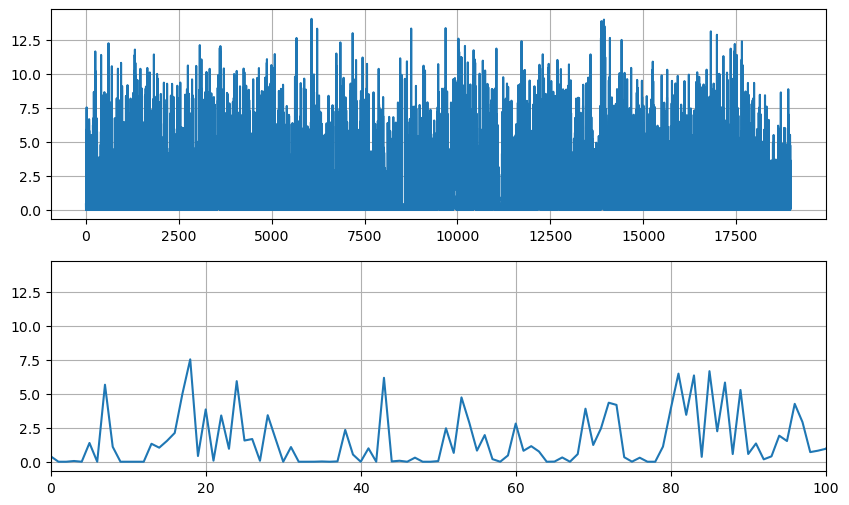

In [8]:
t_gtex_sample_batch = t_sample_batch.detach().cpu().numpy()
sample_idx = 11

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6))

ax1.plot(t_gtex_sample_batch[sample_idx,:])
ax1.grid('both')

ax2.plot(t_gtex_sample_batch[sample_idx,:])
ax2.set_xlim((0,100))
ax2.grid('both')

plt.show()

### Function to sample from generative model (during training)

Give to the model some random noise distributed according to the prior $p(z) = \mathcal{N}(0, I)$ and send it through the decoder. This process generates samples that look like they come from the original distribution $p(x)$.

In [9]:
def generate_data_and_plot(epoch = -1, n_samples=128):
 
 model.eval()
 random_sequence = torch.randn(n_samples, latent_dim)
 random_sequence = random_sequence.cuda() if use_cuda else random_sequence
 t_generated_data = model.sample(random_sequence)

 generated_data = t_generated_data.detach().cpu().numpy()

 sample_idx = 1

 fig, ax = plt.subplots(2, 1, figsize=(9,5))
 fig_objects.append(fig)
 fig_names.append(f'generated_data: epoch {epoch}')

 ax[0].plot(generated_data[sample_idx,:])
 ax[0].grid('both')
 ax[1].plot(generated_data[sample_idx  ,:], 'r')
 ax[1].plot(generated_data[sample_idx+1,:], 'b')
 ax[1].plot(generated_data[sample_idx+2,:], 'k')
 ax[1].plot(generated_data[sample_idx+3,:], 'g')
 ax[1].plot(generated_data[sample_idx+4,:], 'c')
 ax[1].set_xlim((0,100))
 ax[1].grid('both')

 plt.show()

 return generated_data

### Loss function and optimizer

In [10]:
criterion = torch.nn.MSELoss(reduction='sum')

if use_cuda:
    criterion = criterion.cuda()
    model = model.cuda()
    
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training/validation loop

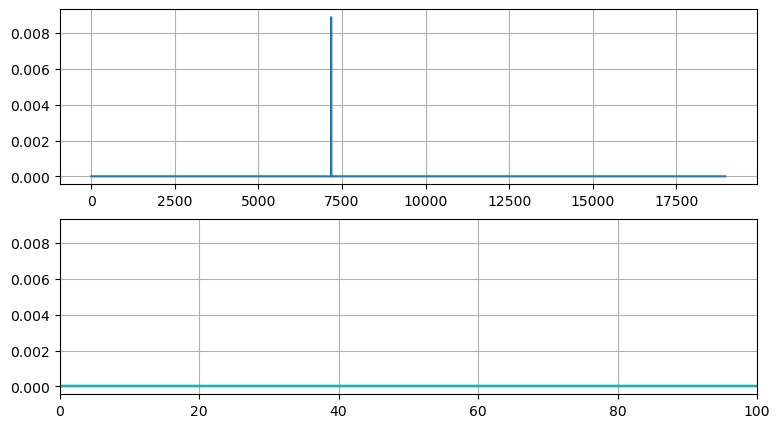

Epoch: 0	train ELBO: 1274087.16212	MSE: 1274087.16212	KLdiv: 0.00000
                val   ELBO: 39988.26548	MSE: 39988.26548	KLdiv: 0.00000



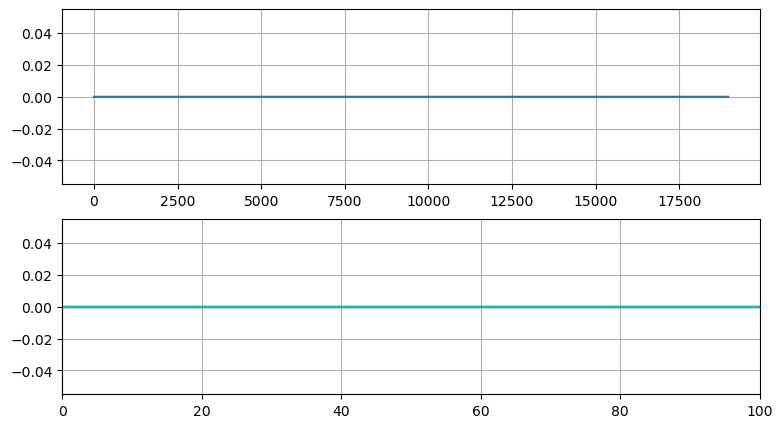

Epoch: 1	train ELBO: 39917.72814	MSE: 39917.72814	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



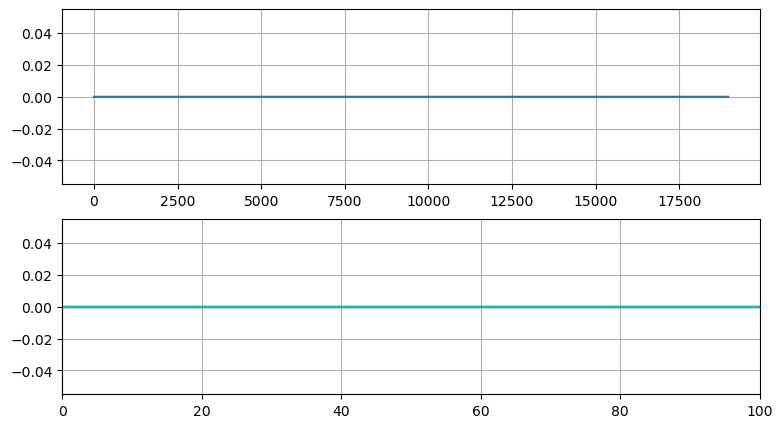

Epoch: 2	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



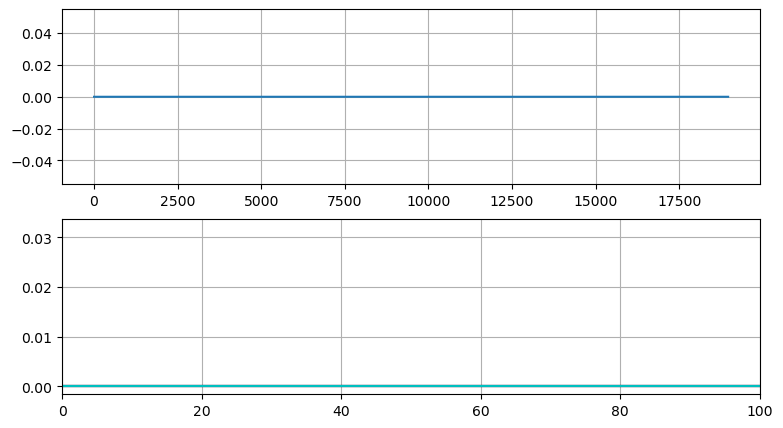

Epoch: 3	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



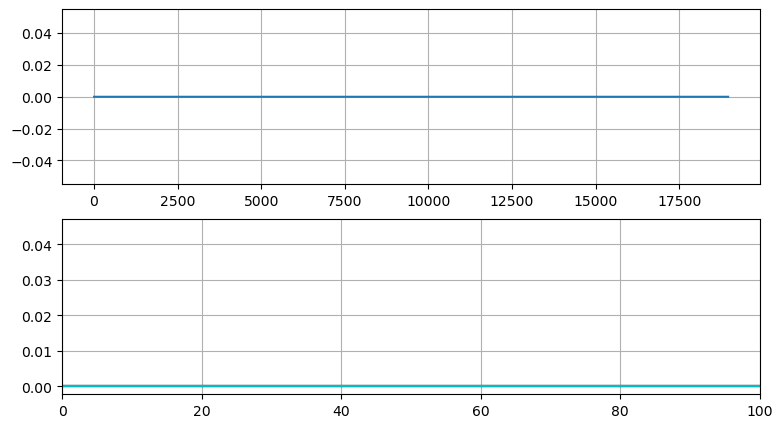

Epoch: 4	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



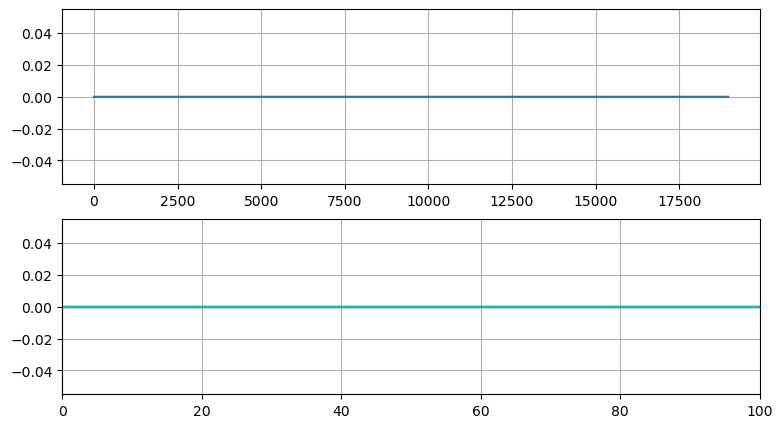

Epoch: 5	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



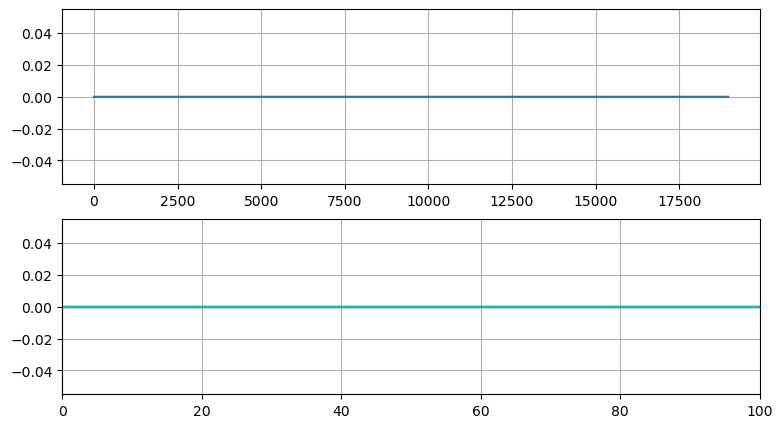

Epoch: 6	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



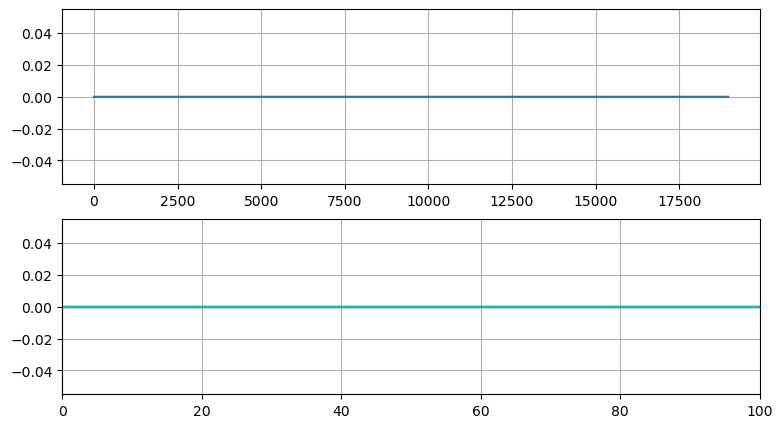

Epoch: 7	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



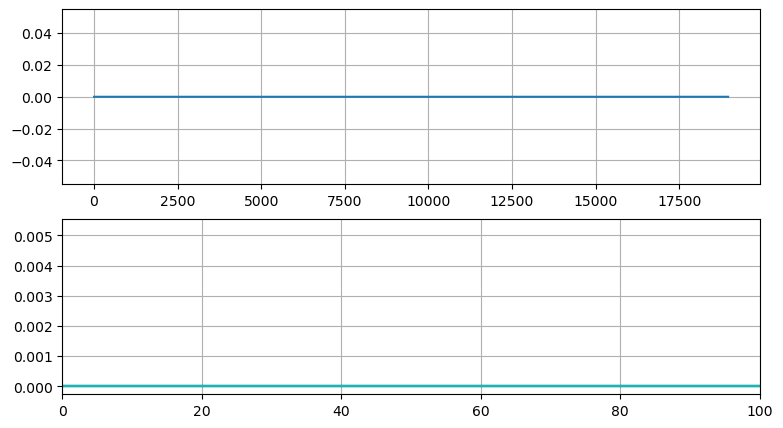

Epoch: 8	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



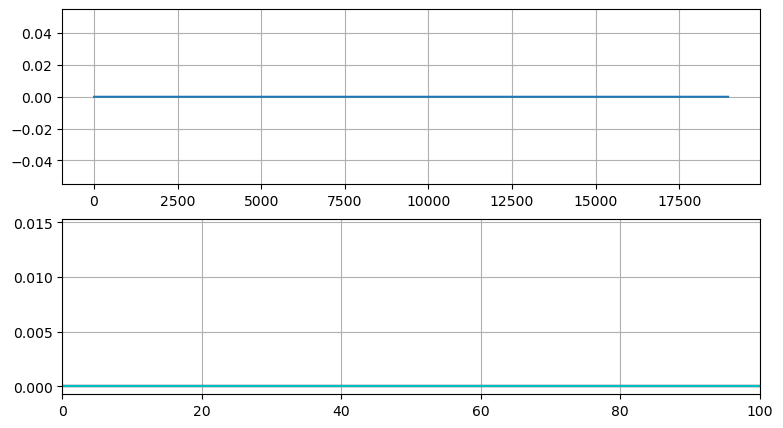

Epoch: 9	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



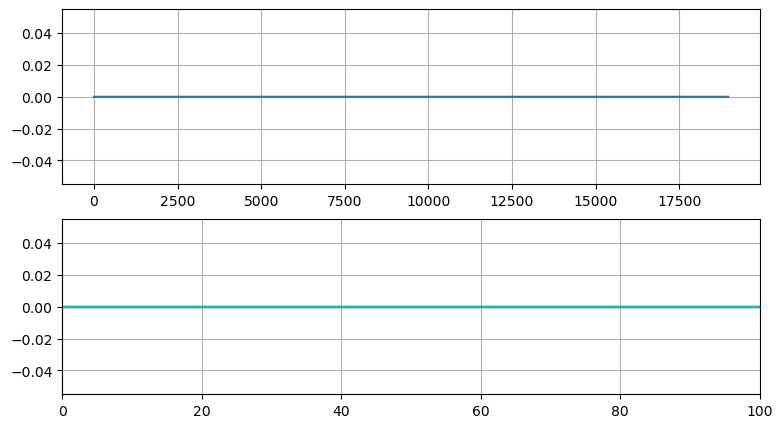

Epoch: 10	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



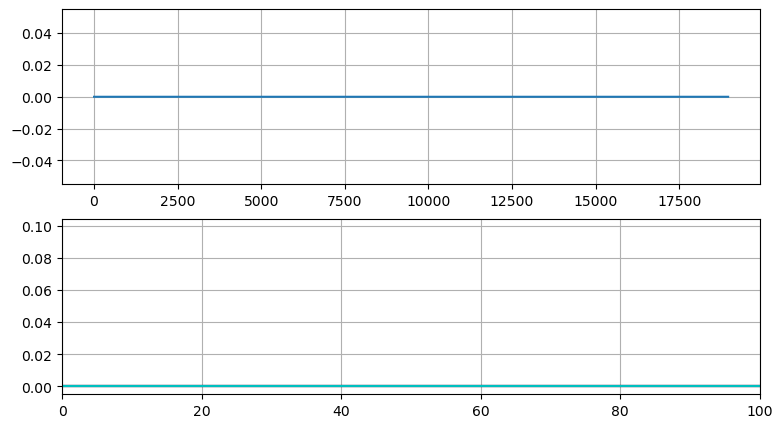

Epoch: 11	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



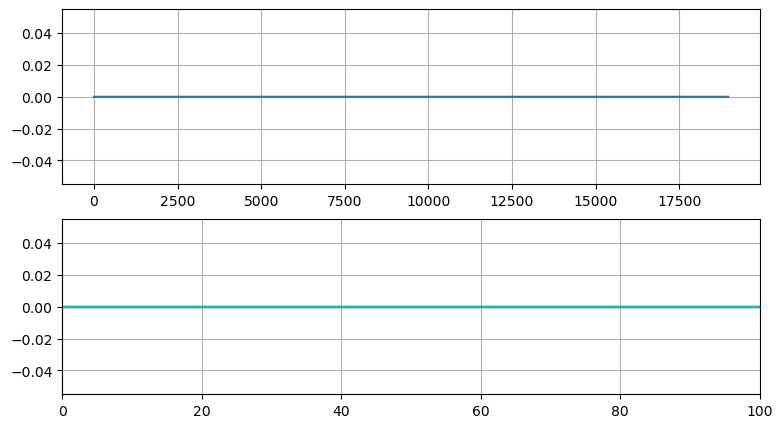

Epoch: 12	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



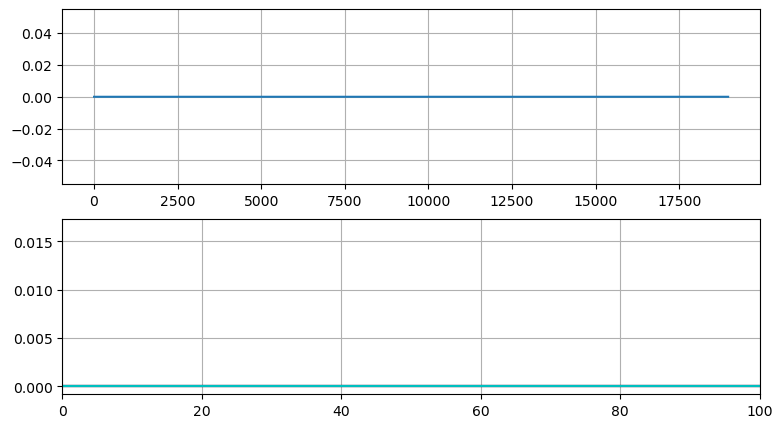

Epoch: 13	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



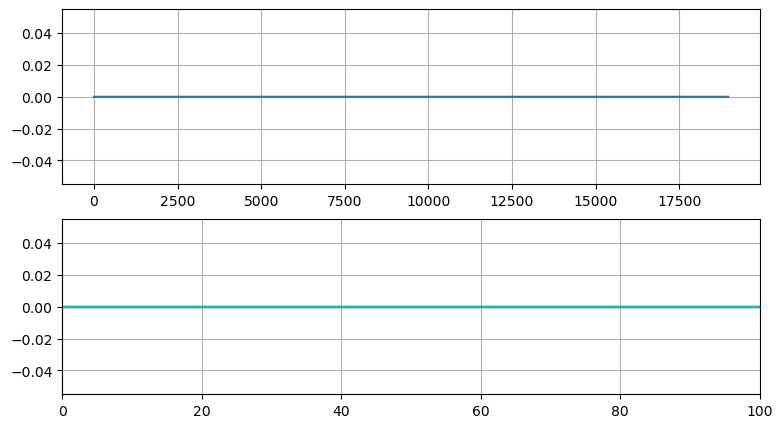

Epoch: 14	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



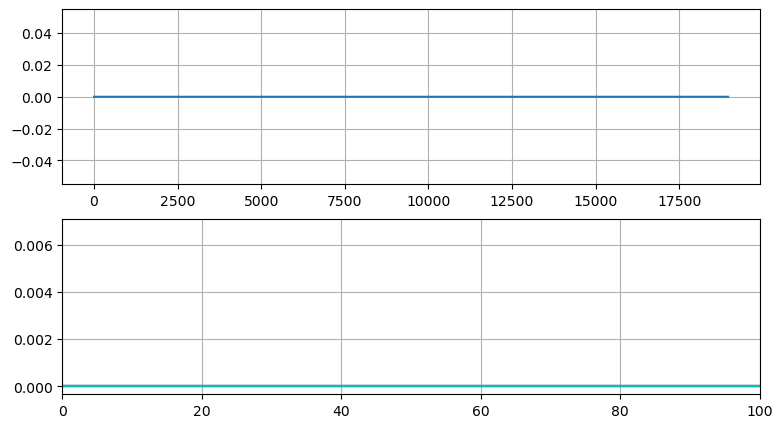

Epoch: 15	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



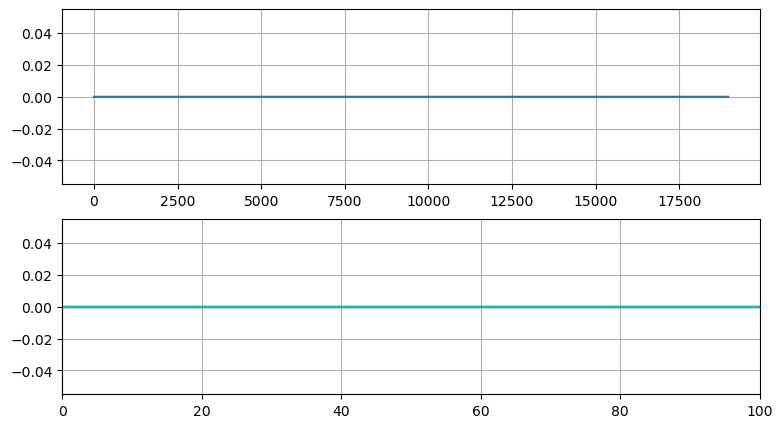

Epoch: 16	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



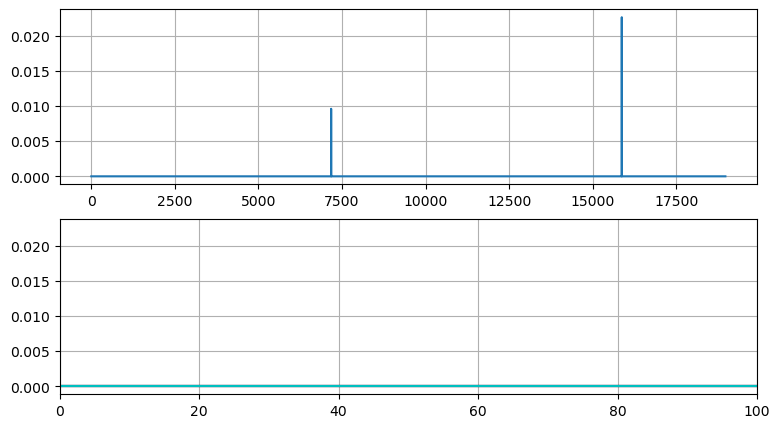

Epoch: 17	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



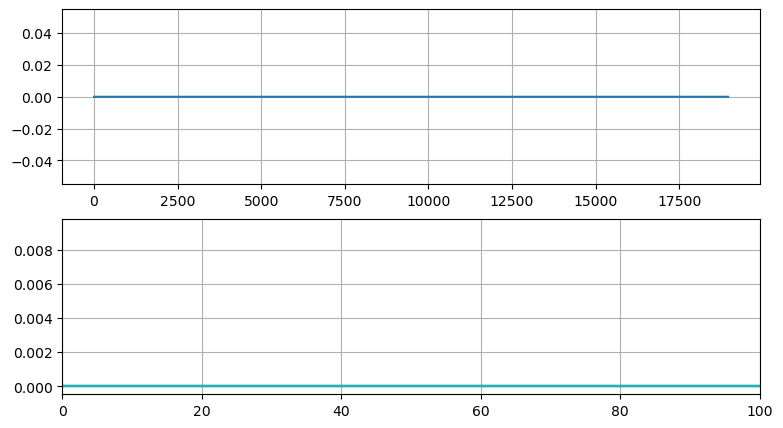

Epoch: 18	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000



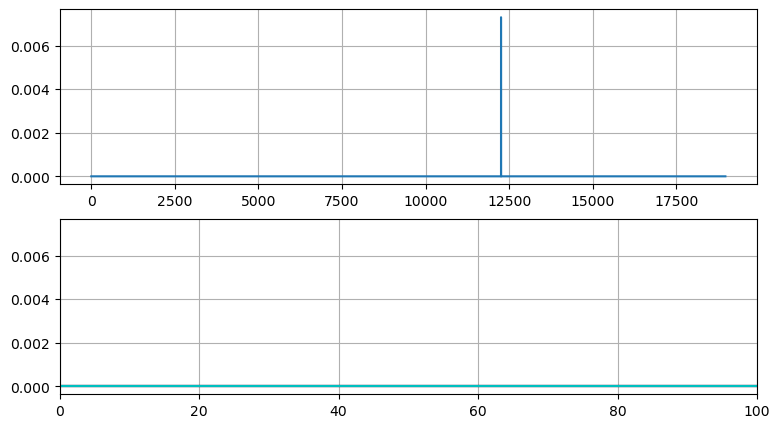

Epoch: 19	train ELBO: 39917.70344	MSE: 39917.70344	KLdiv: 0.00000
                val   ELBO: 39988.26445	MSE: 39988.26445	KLdiv: 0.00000

Max value after normalization: 0.99


In [11]:
log_train_ELBO_m       = np.zeros([TRAIN_EPOCHS, len(train_dl)])
log_train_MSE_m        = np.zeros([TRAIN_EPOCHS, len(train_dl)])
log_train_KLdiv_m      = np.zeros([TRAIN_EPOCHS, len(train_dl)])
log_val_ELBO_m         = np.zeros([TRAIN_EPOCHS, len(val_dl)])
log_val_MSE_m          = np.zeros([TRAIN_EPOCHS, len(val_dl)])
log_val_KLdiv_m        = np.zeros([TRAIN_EPOCHS, len(val_dl)])

log_manual_KLdiv_m     = np.zeros([TRAIN_EPOCHS, len(train_dl)])
log_manual_qz_m        = np.zeros([TRAIN_EPOCHS, len(train_dl)])
log_manual_pz_m        = np.zeros([TRAIN_EPOCHS, len(train_dl)])
log_manual_z_mu_m      = np.zeros([TRAIN_EPOCHS, len(train_dl)])
log_manual_z_log_var_m = np.zeros([TRAIN_EPOCHS, len(train_dl)])

# Matrix structure:
#    ----- batches -----> 
#   |
# epochs
#   |
#   v

max_feature = 0

latent_representations = []

for epoch in range(TRAIN_EPOCHS):
    model.train()

    epoch_train_ELBO  = 0
    epoch_train_MSE   = 0
    epoch_train_KLdiv = 0
    epoch_val_ELBO    = 0
    epoch_val_MSE     = 0
    epoch_val_KLdiv   = 0    
    batch_counter     = 0
    
    # TRAINING LOOP
    for u in train_dl:
        u = u[:,:input_dim] / MAX_FEATURE_VALUE # quick and dirt normalization
        if torch.max(u) > max_feature:
            max_feature = torch.max(u)
            
        if use_cuda: u = u.cuda()

        reconstruction = model(u)
        
        MSE_batch = ELBO_GAIN * criterion(reconstruction, u)
        KLdiv_batch = ELBO_GAIN * BETA * torch.mean(model.kl_divergence)

        # MANUAL calculation of KL_div:        
        z, z_mu, z_log_var = model.encoder(u)            
        # pz: log prob. of "z" under PRIOR N(0,1). The higher (closer to zero) the more likely "z" is the prior.
        pz = log_standard_gaussian(z)
        # qz: log prob. of "z" under the Gaussian given "x". The higher (closer to zero)) the more likely "z" is to encode "x" according to the model.
        qz = log_gaussian(z, z_mu, z_log_var) 
        kl = qz - pz            
        log_manual_z_mu_m[epoch, batch_counter]      = z_mu.mean().item()
        log_manual_z_log_var_m[epoch, batch_counter] = z_log_var.mean().item()
        log_manual_qz_m[epoch, batch_counter]        = qz.mean().item()
        log_manual_pz_m[epoch, batch_counter]        = pz.mean().item()
        log_manual_KLdiv_m[epoch, batch_counter]     = BETA * kl.mean().item()        

        # ELBO is maximized in a VAE.
        # By inverting ELBO, the terms inside are in practice minimized:
        # minimizing mse_loss -> good sample reconstruction
        # minimizing KL_div   -> "moves" distribution of latent vars towards prior distributions (acting as a regularizer)
        ELBO_batch = (MSE_batch + KLdiv_batch)
                
        ELBO_batch.backward()
        optimizer.step()
        optimizer.zero_grad()
                        
        log_train_MSE_m[epoch, batch_counter]   = MSE_batch
        log_train_KLdiv_m[epoch, batch_counter] = KLdiv_batch.item()
        log_train_ELBO_m[epoch, batch_counter]  = ELBO_batch.item()

        batch_counter += 1        

    train_ELBO_epoch_now  = log_train_ELBO_m[epoch, :].mean(axis=0)
    train_MSE_epoch_now   = log_train_MSE_m[epoch, :].mean(axis=0)
    train_KLdiv_epoch_now = log_train_KLdiv_m[epoch, :].mean(axis=0)

    # VALIDATION LOOP
    batch_counter = 0
    model.eval()
    _ = generate_data_and_plot(epoch)

    with torch.inference_mode():                
        for u in val_dl:
            u = u[:,:input_dim] / MAX_FEATURE_VALUE # quick and dirt normalization

            if use_cuda: u = u.cuda()

            # Get latent variables
            z, _, _ = model.encoder.get_latent_vars(u)
            latent_representations.append(z.detach().cpu().numpy())

            reconstruction = model(u)
            MSE_batch = ELBO_GAIN * criterion(reconstruction, u)
            KLdiv_batch = ELBO_GAIN * BETA * torch.mean(model.kl_divergence)
            ELBO_batch = (MSE_batch + KLdiv_batch)            
            
            log_val_MSE_m[epoch, batch_counter]   = MSE_batch
            log_val_KLdiv_m[epoch, batch_counter] = KLdiv_batch.item()
            log_val_ELBO_m[epoch, batch_counter]  = ELBO_batch.item()
            batch_counter += 1        
            
    # PRINT RESULTS per EPOCH            
    val_ELBO_epoch_now  = log_val_ELBO_m[epoch, :].mean(axis=0)            
    val_MSE_epoch_now   = log_val_MSE_m[epoch, :].mean(axis=0)
    val_KLdiv_epoch_now = log_val_KLdiv_m[epoch, :].mean(axis=0)

    if (epoch >= 2):
        overfit_warning_str = ''        
        val_ELBO_epoch_old1 = log_val_ELBO_m[epoch-1, :].mean(axis=0)
        val_ELBO_epoch_old2 = log_val_ELBO_m[epoch-2, :].mean(axis=0)

        # Naive overfit detection (where validation goes down and then up)
        if np.min([val_ELBO_epoch_now, val_ELBO_epoch_old1, val_ELBO_epoch_old2]) == val_ELBO_epoch_old1:
            overfit_warning_str = ' <--- Possible overfit'

    print(f'Epoch: {epoch}\ttrain ELBO: {train_ELBO_epoch_now:2.5f}\tMSE: {train_MSE_epoch_now:2.5f}\tKLdiv: {train_KLdiv_epoch_now:2.5f}')
    print(f'                val   ELBO: {val_ELBO_epoch_now:2.5f}\tMSE: {val_MSE_epoch_now:2.5f}\tKLdiv: {val_KLdiv_epoch_now:2.5f}\n')


# List of arrays -> single numpy array
latent_representations = np.concatenate(latent_representations, axis=0)
print(f'Max value after normalization: {max_feature:2.2f}')
if max_feature > 0: print(f'WARNING: Max value after normalization exceeds 1')

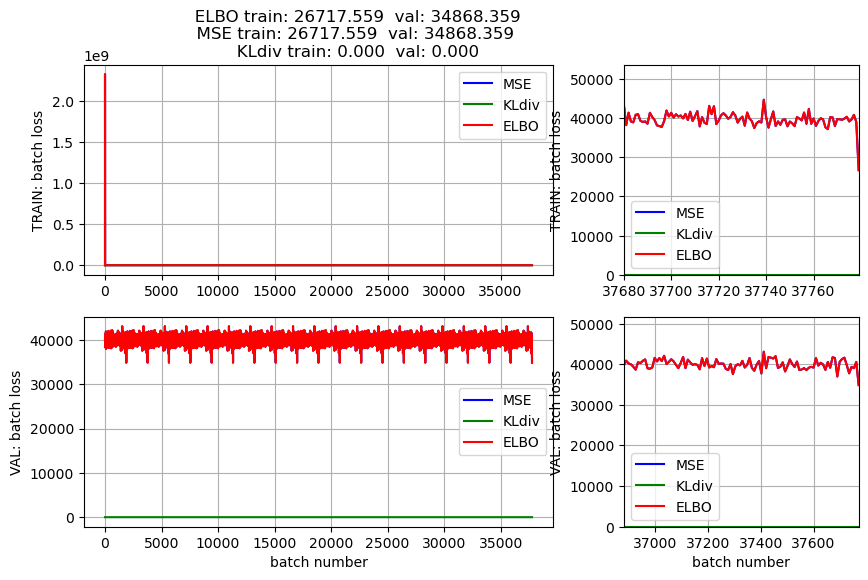

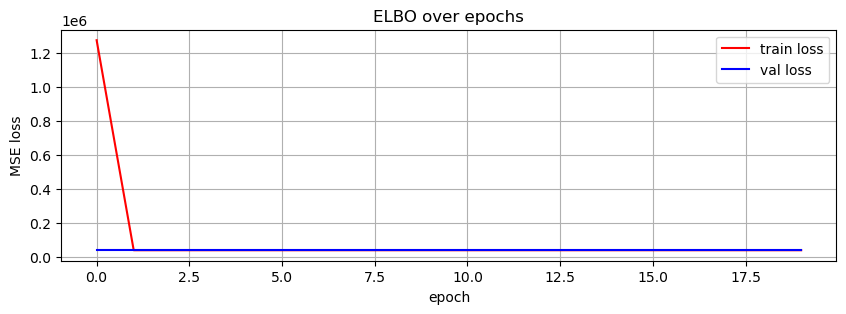

In [12]:
# concatenate recorded batch losses for each epoch
train_ELBO_vs_all_batches  = log_train_ELBO_m.reshape(TRAIN_EPOCHS*len(train_dl),1).squeeze()
val_ELBO_vs_all_batches    = log_val_ELBO_m.reshape(TRAIN_EPOCHS*len(val_dl),1).squeeze()
train_MSE_vs_all_batches   = log_train_MSE_m.reshape(TRAIN_EPOCHS*len(train_dl),1).squeeze()
val_MSE_vs_all_batches     = log_val_MSE_m.reshape(TRAIN_EPOCHS*len(val_dl),1).squeeze()
train_KLdiv_vs_all_batches = log_train_KLdiv_m.reshape(TRAIN_EPOCHS*len(train_dl),1).squeeze()
val_KLdiv_vs_all_batches   = log_val_KLdiv_m.reshape(TRAIN_EPOCHS*len(val_dl),1).squeeze()

batch_ratio   = len(train_ELBO_vs_all_batches) / len(val_ELBO_vs_all_batches)
xaxis_train_v = np.arange(len(train_MSE_vs_all_batches))
xaxis_val_v   = np.arange(len(val_MSE_vs_all_batches)) * batch_ratio
zoom_idx1     = -100
zoom_idx2     = -1

# 2x2 grid 
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 2])
fig_objects.append(fig)
fig_names.append("train_val_losses")

ax1 = plt.subplot(gs[0,0])
ax1.plot(xaxis_train_v, train_MSE_vs_all_batches, 'b')  
ax1.plot(xaxis_train_v, train_KLdiv_vs_all_batches, 'g')  
ax1.plot(xaxis_train_v, train_ELBO_vs_all_batches, 'r')  
ax1.legend(['MSE', 'KLdiv', 'ELBO'])
ax1.set_ylabel('TRAIN: batch loss') 
ax1.set_title(f'               ELBO train: {train_ELBO_vs_all_batches[-1]:2.3f}  val: {val_ELBO_vs_all_batches[-1]:2.3f}\n\
              MSE train: {train_MSE_vs_all_batches[-1]:2.3f}  val: {val_MSE_vs_all_batches[-1]:2.3f}\n\
               KLdiv train: {train_KLdiv_vs_all_batches[-1]:2.3f}  val: {val_KLdiv_vs_all_batches[-1]:2.3f}')

ax1.grid('both')

ax2 = plt.subplot(gs[1,0])
ax2.plot(xaxis_val_v, val_MSE_vs_all_batches, 'b')  
ax2.plot(xaxis_val_v, val_KLdiv_vs_all_batches, 'g')  
ax2.plot(xaxis_val_v, val_ELBO_vs_all_batches, 'r')  
ax2.legend(['MSE', 'KLdiv', 'ELBO'])
ax2.set_xlabel('batch number')
ax2.set_ylabel('VAL: batch loss') 
ax2.grid('both')

ax3 = plt.subplot(gs[0,1])
ax3.plot(xaxis_train_v, train_MSE_vs_all_batches, 'b')  
ax3.plot(xaxis_train_v, train_KLdiv_vs_all_batches, 'g')  
ax3.plot(xaxis_train_v, train_ELBO_vs_all_batches, 'r')  
ax3.legend(['MSE', 'KLdiv', 'ELBO'], loc='lower left')
ax3.set_ylabel('TRAIN: batch loss') 
ax3.set_xlim(xaxis_train_v[zoom_idx1], xaxis_train_v[zoom_idx2])
ax3.set_ylim(0, 1.2*np.max(train_ELBO_vs_all_batches[zoom_idx1:zoom_idx2]))
ax3.grid('both')

ax4 = plt.subplot(gs[1,1])
ax4.plot(xaxis_val_v, val_MSE_vs_all_batches, 'b')  
ax4.plot(xaxis_val_v, val_KLdiv_vs_all_batches, 'g')  
ax4.plot(xaxis_val_v, val_ELBO_vs_all_batches, 'r')  
ax4.legend(['MSE', 'KLdiv', 'ELBO'], loc='lower left')
ax4.set_xlabel('batch number')
ax4.set_ylabel('VAL: batch loss') 
ax4.set_xlim(xaxis_val_v[zoom_idx1], xaxis_val_v[zoom_idx2])
ax4.set_ylim(0, 1.2*np.max(val_ELBO_vs_all_batches[zoom_idx1:zoom_idx2]))
ax4.grid('both')

plt.show()

fig = plt.figure(figsize=(10,3))
fig_objects.append(fig)
fig_names.append("train_val_elbo_over_epochs")

plt.plot(np.mean(log_train_ELBO_m, axis=1), 'r', label='train loss')
plt.plot(np.mean(log_val_ELBO_m, axis=1), 'b', label='val loss')  
plt.title('ELBO over epochs')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid('both')
plt.legend()
plt.show()

### KL div plot (of manual calculations)

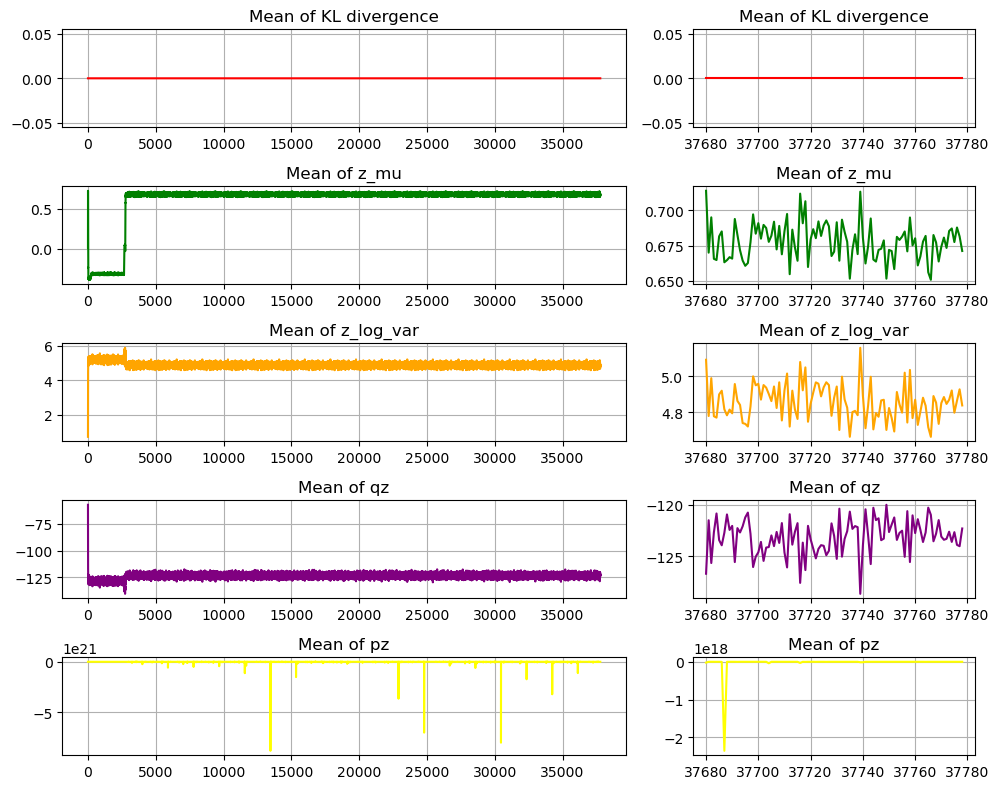

In [13]:
z_mu_vs_all_batches      = log_manual_z_mu_m.reshape(TRAIN_EPOCHS * len(train_dl), 1).squeeze()
z_log_var_vs_all_batches = log_manual_z_log_var_m.reshape(TRAIN_EPOCHS * len(train_dl), 1).squeeze()
qz_vs_all_batches        = log_manual_qz_m.reshape(TRAIN_EPOCHS * len(train_dl), 1).squeeze()
pz_vs_all_batches        = log_manual_pz_m.reshape(TRAIN_EPOCHS * len(train_dl), 1).squeeze()
kl_div_vs_all_batches    = log_manual_KLdiv_m.reshape(TRAIN_EPOCHS * len(train_dl), 1).squeeze()

# 4x2 grid 
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(5, 2, width_ratios=[4, 2])
fig_objects.append(fig)
fig_names.append("kldiv_intermediate_calcs")

ax_0_0 = plt.subplot(gs[0,0])
ax_0_0.plot(xaxis_train_v, kl_div_vs_all_batches, 'r')
ax_0_0.set_title('Mean of KL divergence')
ax_0_0.grid(True)


ax_1_0 = plt.subplot(gs[1,0])
ax_1_0.plot(xaxis_train_v, z_mu_vs_all_batches, 'g')
ax_1_0.set_title('Mean of z_mu')
ax_1_0.grid('both')

ax_2_0 = plt.subplot(gs[2,0])
ax_2_0.plot(xaxis_train_v, z_log_var_vs_all_batches, 'orange')
ax_2_0.set_title('Mean of z_log_var')
ax_2_0.grid('both')

ax_3_0 = plt.subplot(gs[3,0])
ax_3_0.plot(xaxis_train_v, qz_vs_all_batches, 'purple')
ax_3_0.set_title('Mean of qz')
ax_3_0.grid('both')

ax_4_0 = plt.subplot(gs[4,0])
ax_4_0.plot(xaxis_train_v, pz_vs_all_batches, 'yellow')
ax_4_0.set_title('Mean of pz')
ax_4_0.grid('both')

# ZOOM
ax_0_1 = plt.subplot(gs[0,1])
ax_0_1.plot(xaxis_train_v[zoom_idx1:zoom_idx2], kl_div_vs_all_batches[zoom_idx1:zoom_idx2], 'r')
ax_0_1.set_title('Mean of KL divergence')
ax_0_1.grid('both')

ax_1_1 = plt.subplot(gs[1,1])
ax_1_1.plot(xaxis_train_v[zoom_idx1:zoom_idx2], z_mu_vs_all_batches[zoom_idx1:zoom_idx2], 'g')
ax_1_1.set_title('Mean of z_mu')
ax_1_1.grid('both')

ax_2_1 = plt.subplot(gs[2,1])
ax_2_1.plot(xaxis_train_v[zoom_idx1:zoom_idx2], z_log_var_vs_all_batches[zoom_idx1:zoom_idx2], 'orange')
ax_2_1.set_title('Mean of z_log_var')
ax_2_1.grid('both')

ax_3_1 = plt.subplot(gs[3,1])
ax_3_1.plot(xaxis_train_v[zoom_idx1:zoom_idx2], qz_vs_all_batches[zoom_idx1:zoom_idx2], 'purple')
ax_3_1.set_title('Mean of qz')
ax_3_1.grid('both')

ax_4_1 = plt.subplot(gs[4,1])
ax_4_1.plot(xaxis_train_v[zoom_idx1:zoom_idx2], pz_vs_all_batches[zoom_idx1:zoom_idx2], 'yellow')
ax_4_1.set_title('Mean of pz')
ax_4_1.grid('both')

plt.tight_layout()
plt.show()

## Sampling from the generative model

Now that we have trained the network, we can begin to sample from it. We simply give it some random noise distributed according to the prior $p(z) = \mathcal{N}(0, I)$ and send it through the decoder. This process generates a slew of samples that look like they come from the original distribution $p(x)$.

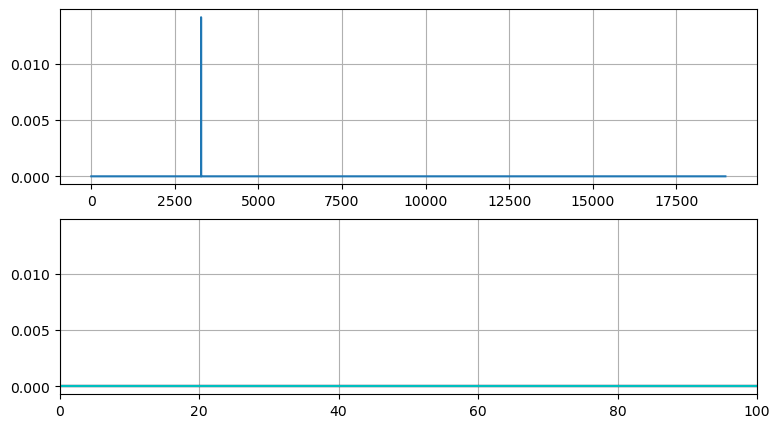

In [14]:
generated_data = generate_data_and_plot()

## PCA analysis:
- Make a PCA on the training data and transform it.
- Transform the generated data with the found pca's above.
- Plot both transformed data sets to assess whether they are in similar regions.

`IncrementalPCA` is used to perform the PCA in batches (due to memory limitations).

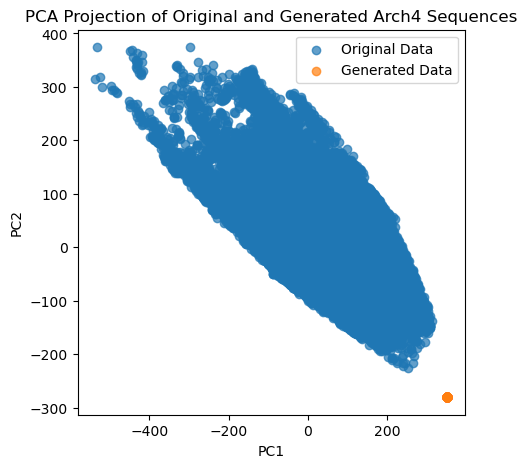

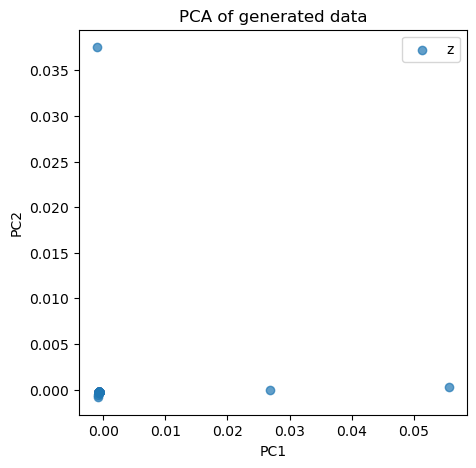

In [15]:
from sklearn.decomposition import IncrementalPCA
import numpy as np
import matplotlib.pyplot as plt

# Incremental PCA
n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=BATCH_SIZE)

# Fit IPCA on training data
for data in train_dl:
    data = data[:,:input_dim] 
    ipca.partial_fit(data.cpu().numpy())

# Transform generated data
generated_data_transformed = ipca.transform(generated_data)

# Transform original data (in batches)
def transform_in_batches(dataloader, pca_model):
    transformed_data_list = []
    for data in dataloader:
        data = data[:,:input_dim]
        transformed_batch = pca_model.transform(data.cpu().numpy())
        transformed_data_list.append(transformed_batch)
    return np.concatenate(transformed_data_list, axis=0)

original_data_transformed = transform_in_batches(train_dl, ipca)

fig = plt.figure(figsize=(5, 5))
fig_objects.append(fig)
fig_names.append("IPCA_orig_vs_generated_data")

# Original data
plt.scatter(original_data_transformed[:, 0], original_data_transformed[:, 1], alpha=0.7, label='Original Data')
# Generated data
plt.scatter(generated_data_transformed[:, 0], generated_data_transformed[:, 1], alpha=0.7, label='Generated Data')

plt.title('PCA Projection of Original and Generated Arch4 Sequences')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## OUTPUT DATA
pca_output = PCA(n_components=n_components)
pca_gen_data = pca_output.fit_transform(generated_data)

fig = plt.figure(figsize=(5, 5))
fig_objects.append(fig)
fig_names.append("PCA_generated_data")

plt.scatter(pca_gen_data[:, 0], pca_gen_data[:, 1], alpha=0.7, label='z')
plt.title('PCA of generated data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


### PCA analysis on the latent representation

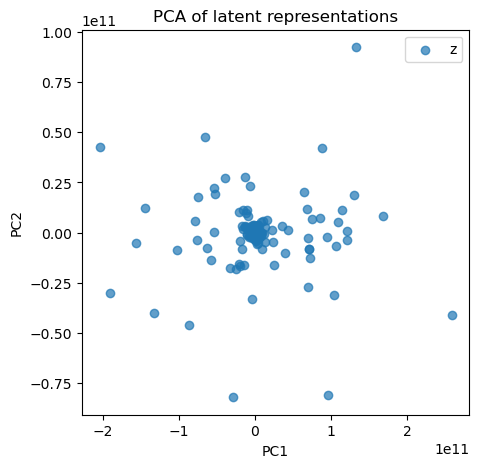

In [16]:
n_components = 2

pca = PCA(n_components=n_components)
latent_pca = pca.fit_transform(latent_representations)

fig = plt.figure(figsize=(5, 5))
fig_objects.append(fig)
fig_names.append("PCA_of_latent_representations")

plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.7, label='z')
plt.title('PCA of latent representations')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

#### Save results

In [17]:
save_results('results_latests/parameters.txt', fig_objects, fig_names)